<a href="https://colab.research.google.com/github/backjiung/baek/blob/master/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [1]:
try:
  import lanemod
except (ImportError, KeyError, ModuleNotFoundError):
  !git clone https://github.com/HyungunKim/Software-Fusion-Technology.git ./Project
  !pip install -e ./Project
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
  exit()

In [2]:
from google.colab import files
import os
if not 'data' in os.listdir():
  files.upload() #upload kaggle.json
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle datasets download -d hyunkunkookminuniv/behavioralcloning
  !unzip -q behavioralcloning.zip -d ./data

Saving kaggle.json to kaggle.json
kaggle.json
 99% 1.08G/1.09G [00:07<00:00, 159MB/s]
100% 1.09G/1.09G [00:07<00:00, 162MB/s]


In [3]:
import glob
import shutil
import os
import random
from PIL import Image

import pandas as pd
import numpy as np
from tqdm import notebook

import matplotlib.pyplot as plt

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras 

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Input, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization,Add,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LeakyReLU, ReLU, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


텐서플로우 관련 라이브러리를 import 해준다.

In [5]:
df = pd.read_csv('/content/data/data1/log.csv')
print(len(df))

804


데이터 프레임의 형태를 log를 통해 확인

In [6]:
df.head()

,t,x,y,z,pitch,yaw,roll,vx,vy,vz,throttle,steer,brake,reverse,gear
0,0.033333,-256.0,-11.999998,-0.018810,-0.000581,179.999954,-0.000671,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,False,0
1,0.333333,-256.0,-11.999998,-0.019682,-0.000581,179.999954,-0.000671,1.093149e-08,7.887701e-08,0.001220,0.621264,0.011783,0.621264,False,0
2,0.666667,-256.0,-11.999998,-0.019444,-0.000581,179.999954,-0.000671,2.025853e-08,3.042292e-08,0.000380,0.363130,0.011783,0.621264,False,0
3,0.966667,-256.0,-11.999998,-0.019400,-0.000581,179.999954,-0.000671,4.079034e-09,6.914056e-08,0.000013,0.358104,-0.004398,0.621264,False,0
4,1.300000,-256.0,-11.999998,-0.019398,-0.000581,179.999954,-0.000671,2.485921e-08,8.699285e-09,0.000001,0.382976,-0.012589,0.621264,False,0


head 함수를 통해 데이를 수집한 시간, x,y,z좌표, 속도, 스티어링, 브레이크, 기어 등등을 확인할 수 있다.
데이터가 누락될 경우 데이터프레임에서도 누락되어있게 설계되었다


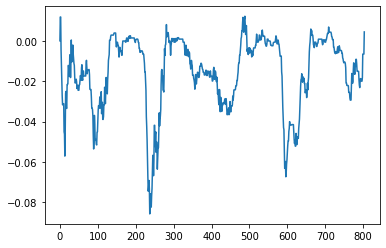

In [7]:
plt.plot(df.steer)

사람이 주행 중 스티어링을 최대한 돌리지 않으려하는 원인으로 절댓값의 최솟값이 작다.?

In [8]:
log_df1 = pd.read_csv('/content/data/data1/log.csv')
log_df2 = pd.read_csv('/content/data/data2/log.csv')
log_df3 = pd.read_csv('/content/data/data3/log.csv')
log_df4 = pd.read_csv('/content/data/data4/log.csv')

logs = [log_df1 , log_df2, log_df3, log_df4]

for i in range(len(logs)):
    logs[i] = 10*logs[i]['steer'].values
    
    logs[i][logs[i] > 1] = 1.0
    logs[i][logs[i] < -1] = -1.0
    logs[i] += 1
    logs[i] /= 2

주행log들에 10을 곱해주고 절댓값이 1이 넘으면 1또는 -1로 대치해준다. 0~1사이의 범위를 갖게 한다.

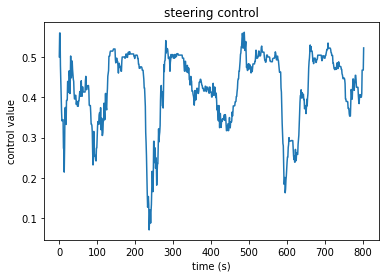

In [9]:
plt.plot(logs[0])
plt.xlabel("time (s)")
plt.ylabel("control value")
plt.title("steering control")
plt.show()

0과 1사이의 범위를 갖는 데이터로 변환한다.

In [10]:
class Autonomous_Model(keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(24, 5, padding='valid')
        self.mp1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')
        
        self.conv2 = Conv2D(36, 5, padding='valid')
        self.mp2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')
        
        self.conv3 = Conv2D(48, 5, padding='valid')
        self.mp3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')

        self.conv4 = Conv2D(64, 3, padding='valid')
        self.mp4 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')

        self.conv5 = Conv2D(64, 3, padding='valid')
        self.mp5 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')

        self.flatten = tf.keras.layers.Flatten()

        self.d1 = Dense(1164)

        self.d2 = Dense(100)

        self.d3 = Dense(50) 
        self.d4 = Dense(10)
        self.d5 = Dense(1)


    def call(self, input_tensor, *args, **kwargs):
        x = self.conv1(input_tensor)#24개의 픽쳐를 만들어줌
        x = tf.nn.relu(x)
        x = self.mp1(x)

        x = self.conv2(x)
        x = tf.nn.relu(x)
        x = self.mp2(x)

        x = self.conv3(x)
        x = tf.nn.relu(x)
        x = self.mp3(x)

        x = self.conv4(x)
        x = tf.nn.relu(x)
        x = self.mp4(x)

        x = self.conv5(x)
        x = tf.nn.relu(x)
        x = self.mp5(x)

       
        x= self.flatten(x)
        
        x= self.d1(x)
        x=tf.nn.relu(x)

        x= self.d2(x)
        x=tf.nn.relu(x)

        x= self.d3(x)
        x=tf.nn.relu(x)

        x= self.d4(x)
        x=tf.nn.relu(x)

        x= self.d5(x)
        x=tf.nn.relu(x)
        #call함수가 실행될 수 있게
        
        return tf.nn.sigmoid(x)

        return tf.keras.activations.sigmoid(x)

In [11]:
Steer_model = Autonomous_Model()

Steer_model.compile(optimizer='Adam', loss = 'BCE',  metrics=['mae'])
Steer_model.build(input_shape=(None, 256,512,3))
Steer_model.summary()

Model: "autonomous__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1824      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  21636     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           multiple                  43248     
                                                                 
 max_pooling2d_2 (MaxPooling  multiple           

In [13]:
class steer_loader(Sequence):
    def __init__(self, img_path, labels, batch_size = 16, shuffle = False, flip=False, bias=0, shift=False, rotate=False):
        self.batch_size = batch_size
        self.img_path = img_path
        self.img_list_c = sorted(os.listdir(self.img_path+"center/rgb/"))
        self.img_list_l = sorted(os.listdir(self.img_path+"left/rgb/"))
        self.img_list_r = sorted(os.listdir(self.img_path+"right/rgb/"))#좌우 카메라의 이미지 인덱스를 불러온다
        self.labels = labels
        self.dataset_size = len(self.img_list_c)
        self.shuffle = shuffle
        self.flip = flip
        self.on_epoch_end()
        self.bias = bias
        self.shift = shift
        self.rotate = rotate
        
    def __len__(self):

        return int(np.floor(self.dataset_size) / self.batch_size)
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.dataset_size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):

        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        cur_batch_name_list = [self.img_list_c[k] for k in indexes]
        label_list = np.array([self.labels[k] for k in indexes])
        
        data_list = []
        for i, data in enumerate(cur_batch_name_list):
            if self.shift:
                img_from = np.random.choice(["center/rgb/", "left/rgb/", "right/rgb/"])
            else:
                img_from = "center/rgb/"
            if img_from == "left/rgb/":#왼쪽을 보면 오른쪽 스티어링
                label_list[i] += self.bias
                data = self.img_list_l[indexes[i]]
            if img_from == "right/rgb/":#오른쪽이면 왼쪽 스티어링(bias)
                label_list[i] -= self.bias
                data = self.img_list_r[indexes[i]]

            img_data = np.array(image.img_to_array(Image.open(self.img_path + img_from + data)))/255#8비트 정수형을 실수형으로 변환
            img_data = img_data[:,:,:3]

            
            if self.flip and np.random.uniform() > 0.5:
                img_data = img_data[:,::-1,:]
                label_list[i] = 1 - label_list[i]


            data_list.append(img_data)
        data_list = np.array(data_list)
        data_list = tf.convert_to_tensor(data_list, dtype=tf.float32)
        return data_list , label_list

In [14]:
train_loader1 =  steer_loader('/content/data/data1/', logs[0],flip=True, shift=True, bias=0.05, rotate=False)
train_loader2 =  steer_loader('/content/data/data2/', logs[1],flip=True, shift=True, bias=0.05, rotate=False)
train_loader3 =  steer_loader('/content/data/data3/', logs[2],flip=False, bias=0.05, rotate=False)

val_loader = steer_loader('/content/data/data3/', logs[2],flip=True)

test_loader = steer_loader('/content/data/data4/', logs[3], shuffle = False, flip=True)

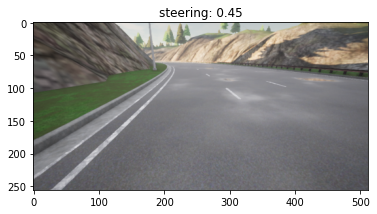

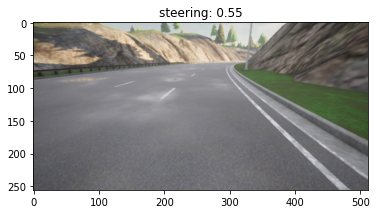

In [15]:
imgs, labels = train_loader1.__getitem__(2)

i = 10
plt.imshow(imgs[i])
plt.title(f"steering: {labels[i]:.2f}")
plt.show()

plt.imshow(imgs[i][:,::-1,:])
plt.title(f"steering: {1 - labels[i]:.2f}")
plt.show()

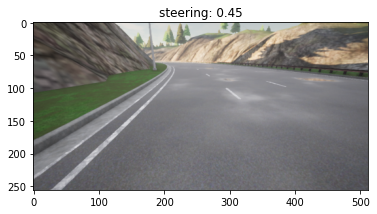

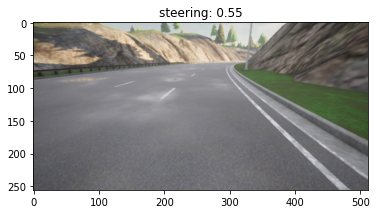

In [16]:
i = 10
plt.imshow(imgs[i])
plt.title(f"steering: {labels[i]:.2f}")
plt.show()
plt.imshow(imgs[i][:,::-1,:])
plt.title(f"steering: {1 - labels[i]:.2f}")
plt.show()

In [17]:
for i in range(3):
    Steer_model.fit(train_loader1, validation_data = val_loader, epochs=1)

    Steer_model.fit(train_loader2, validation_data = val_loader, epochs=1)

    Steer_model.fit(train_loader3, validation_data = val_loader, epochs=1)

10/10 [==============================] - 4s 446ms/step - loss: 0.6931 - mae: 0.1068 - val_loss: 0.6931 - val_mae: 0.1068


  0%|          | 0/9 [00:00<?, ?it/s]

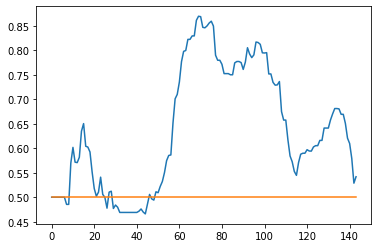

In [22]:
test_loader = steer_loader('/content/data/data4/', logs[3], shuffle = False, flip=False)
target = []
pred = []
a = 0
for data, label in notebook.tqdm(test_loader):
    y_pred = Steer_model(data)
    for i, j in zip(label, y_pred):
        target.append(i)
        pred.append(j)

    a += 1
# before 1 epoch
time_idx = np.arange(len(target))
plt.plot(time_idx, target, time_idx, pred)